In [1]:
# !pip install -q torchtext==0.2.1 torchvision
# !pip install -q torch==1.3.1 torchvision

In [2]:
# !pip install -q torchvision==0.3.1 torchvision

In [3]:
!pip install -q torch==1.3.1 torchvision

In [5]:
# torch.__version__

# Import statements 

In [6]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [7]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
from PIL import Image
import torch.nn as nn
from torchvision.models import vgg19
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure 
import json
import datetime
import copy
from PIL import Image as im
import joblib
from sklearn.model_selection import train_test_split
# import math as Math
import random
import torch.optim

AttributeError: ignored

In [ ]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision

In [ ]:
import cv2
import joblib 

In [9]:
# !pip install scipy==1.1.0

In [10]:

import os
import numpy as np
import h5py
import json
import torch
# from scipy.misc import imread, imresize
from tqdm import tqdm
from collections import Counter
from random import seed, choice, sample

In [11]:
 #Import libraries
import pandas as pd
import numpy as np
# from google.colab import drive
import glob
import string
import nltk
import joblib
import pickle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


In [12]:
import argparse, json, os
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import skimage
import skimage.transform
import torch
import torchvision.transforms as transforms
from math import ceil
from PIL import Image

AttributeError: ignored

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Saving and Loading functions 

In [14]:
# Saving and Loading models using joblib 
def save(filename, obj):
  with open(filename, 'wb') as handle:
      joblib.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load(filename):
  with open(filename, 'rb') as handle:
      return joblib.load(filename)


# Paths  

In [15]:
# # Final folder where all the data saved 
# p = "/content/drive/MyDrive/A4/Method2/"
# output_folder = "data/"



# Reference 

##This code has been referred from the following two sources :
https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning#overview
https://github.com/AaronCCWong

# Preprocessed Files 

In [13]:
# !ls "/content/drive/MyDrive/A4/Method2/data/"
# !ls ./preprocessed_files/
!ls 

drive		     train_captions.json   word_dict.json
sample_data	     train_img_paths.json  word_dict_reverse.json
test_captions.json   val_captions.json
test_img_paths.json  val_img_paths.json


# Dataset Class  

In [43]:
def Image_loader(path):
    # changed so that relative path converted to absolute path here for loading image 
    path = "/content/drive/MyDrive/SEM-2/05-DL /Assignments/A4/Data/myData/" + path
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class ImageCaptionDataset(Dataset):

    def __init__(self, transform, data_path, split_type='train'):
        super(ImageCaptionDataset, self).__init__()
        self.split_type = split_type
        self.transform = transform

        self.word_count = Counter()
        self.caption_img_idx = {}
        self.img_paths = load(data_path + '/{}_img_paths.json'.format(split_type))
        self.captions = load(data_path + '/{}_captions.json'.format(split_type))

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image_loader(img_path)
        if self.transform is not None:
            img = self.transform(img)

        if self.split_type == 'train':
            return torch.FloatTensor(img), torch.tensor(self.captions[idx])

        # all captions related to image 
        matching_idxs = [i for i, path in enumerate(self.img_paths) if path == img_path]
        all_captions = [self.captions[i] for i in matching_idxs]
        # image, caption, all captions related to image 
        return torch.FloatTensor(img), torch.tensor(self.captions[idx]), torch.tensor(all_captions)

    def __len__(self):
        return len(self.captions)

# Models 

## Encoder 

In [44]:
# Encoder using VGG19 
class Encoder(nn.Module):
    def __init__(self, network='vgg19'):
        super(Encoder, self).__init__()

        self.network = network
        self.VGG = vgg19(pretrained=True)
        self.VGG = nn.Sequential(*list(self.VGG.features.children())[:-1])
        self.dim = 512
        # model is fine tunned 
        self.fine_tune()

    def forward(self, x):
        x = self.VGG(x)
        x = x.permute(0, 2, 3, 1)
        x = x.view(x.size(0), -1, x.size(-1))
        return x

    def fine_tune(self, fine_tune=False):

      for p in self.VGG.parameters():
          p.requires_grad = False
      # If fine-tuning, only fine-tune convolutional blocks 2 through 4
      for c in list(self.VGG.children())[5:]:
          for p in c.parameters():
              p.requires_grad = fine_tune
            


## Attention 

In [45]:
class Attention_model(nn.Module):
    def __init__(self, encoder_dim):
        super(Attention_model, self).__init__()
        self.atten_dim = 512
        # converting encoder and hidden representations form decoder to some same dimension
        self.U = nn.Linear(512, self.atten_dim)
        self.W = nn.Linear(encoder_dim, self.atten_dim)
        # Computing attention
        self.v = nn.Linear(512, 1)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(1)

    def forward(self, img_features, hidden_state):
        U_h = self.U(hidden_state).unsqueeze(1)
        W_s = self.W(img_features)
        att = self.tanh(W_s + U_h)
        e = self.v(att).squeeze(2)
        alpha = self.softmax(e)
        image_attended_features = (img_features * alpha.unsqueeze(2)).sum(1)
        # returning image features attended and the attention weights 
        return image_attended_features, alpha


## Decoder 

In [67]:
import torch
import torch.nn as nn
# from attention import Attention


class Decoder(nn.Module):
    def __init__(self, vocabulary_size, encoder_dim, teacher_forcing=False):
        super(Decoder, self).__init__()
        self.use_tf = teacher_forcing

        self.vocabulary_size = vocabulary_size
        self.encoder_dim = encoder_dim
        
        attention_dim = 512
        hidden_dim = 512

        self.init_h = nn.Linear(encoder_dim, attention_dim)
        self.init_c = nn.Linear(encoder_dim, attention_dim)


        self.f_beta = nn.Linear(512, encoder_dim)
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.lstm = nn.LSTMCell(512 + encoder_dim, hidden_dim)
        
        self.deep_output = nn.Linear(512, vocabulary_size)
        self.dropout = nn.Dropout()

        self.attention = Attention_model(encoder_dim)
        self.embedding = nn.Embedding(vocabulary_size, 512)
        

    def forward(self, img_features, captions):
 
        batch = img_features.size(0)
        # generates the hidden representation h,c initally form image features 
        h, c = self.get_init_lstm_state(img_features)
        
        # Calculates the time for the decoder works i.e max caption length-1
        time = max([len(caption) for caption in captions]) - 1
        
        
        prev_words = torch.zeros(batch, 1).long().to(device)
        if self.use_tf:
            # if teacher forcing used embedding initially set to truth value
            embedding = self.embedding(captions) if self.training else self.embedding(prev_words)
        else:
            
            embedding = self.embedding(prev_words)
            
        # prediction and alphas intially 
        preds = torch.zeros(batch, time, self.vocabulary_size).to(device)
        alphas = torch.zeros(batch, time, img_features.size(1)).to(device)
        
        for t in range(time):
            context, alpha = self.attention(img_features, h)
            gate = self.sigmoid(self.f_beta(h))
            gated_context = gate * context

            if self.use_tf and self.training:
                input = torch.cat((embedding[:, t], gated_context), dim=1)
            else:
                embedding = embedding.squeeze(1) if embedding.dim() == 3 else embedding
                input = torch.cat((embedding, gated_context), dim=1)

            h, c = self.lstm(input, (h, c))
            output = self.deep_output(self.dropout(h))

            preds[:, t] = output
            alphas[:, t] = alpha

            if not self.training or not self.use_tf:
                embedding = self.embedding(output.max(1)[1].reshape(batch, 1))
        return preds, alphas

    def get_init_lstm_state(self, img_features):
        # generating initial hidden features for LSTM from the image avg features 
        img_avg = img_features.mean(dim=1)

        c = self.init_c(img_avg)
        c = self.tanh(c)

        h = self.init_h(img_avg)
        h = self.tanh(h)

        return h, c

    def caption(self, img_features, beam_size):
        # Beam Search from https://github.com/AaronCCWong
        
        prev_words = torch.zeros(beam_size, 1).long()

        sentences = prev_words
        top_preds = torch.zeros(beam_size, 1)
        alphas = torch.ones(beam_size, 1, img_features.size(1))

        completed_sentences = []
        completed_sentences_alphas = []
        completed_sentences_preds = []

        step = 1
        h, c = self.get_init_lstm_state(img_features)

        while True:
            embedding = self.embedding(prev_words).squeeze(1)
            context, alpha = self.attention(img_features, h)
            gate = self.sigmoid(self.f_beta(h))
            gated_context = gate * context

            lstm_input = torch.cat((embedding, gated_context), dim=1)
            h, c = self.lstm(lstm_input, (h, c))
            output = self.deep_output(h)
            output = top_preds.expand_as(output) + output

            if step == 1:
                top_preds, top_words = output[0].topk(beam_size, 0, True, True)
            else:
                top_preds, top_words = output.view(-1).topk(beam_size, 0, True, True)
            prev_word_idxs = top_words / output.size(1)

            prev_word_idxs = prev_word_idxs.long()
            next_word_idxs = top_words % output.size(1)

            next_word_idxs = next_word_idxs.long()
            # dtype=long 

            sentences = torch.cat((sentences[prev_word_idxs], next_word_idxs.unsqueeze(1)), dim=1)
            alphas = torch.cat((alphas[prev_word_idxs], alpha[prev_word_idxs].unsqueeze(1)), dim=1)

            incomplete = [idx for idx, next_word in enumerate(next_word_idxs) if next_word != 1]
            complete = list(set(range(len(next_word_idxs))) - set(incomplete))

            if len(complete) > 0:
                completed_sentences.extend(sentences[complete].tolist())
                completed_sentences_alphas.extend(alphas[complete].tolist())
                completed_sentences_preds.extend(top_preds[complete])
            beam_size -= len(complete)

            if beam_size == 0:
                break
            sentences = sentences[incomplete]
            alphas = alphas[incomplete]
            h = h[prev_word_idxs[incomplete]]
            c = c[prev_word_idxs[incomplete]]
            img_features = img_features[prev_word_idxs[incomplete]]
            top_preds = top_preds[incomplete].unsqueeze(1)
            prev_words = next_word_idxs[incomplete].unsqueeze(1)

            if step > 50:
                break
            step += 1

        idx = completed_sentences_preds.index(max(completed_sentences_preds))
        sentence = completed_sentences[idx]
        alpha = completed_sentences_alphas[idx]
        print(sentence, alpha)
        return sentence, alpha

# Utility Functions

In [47]:
class AverageMeter(object):
    
    def __init__(self):
        self.reset_values()

    def reset_values(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def calculate_caption_lengths(word_dict, captions):
    lengths = 0
    for caption_tokens in captions:
        for token in caption_tokens:
            if token in (word_dict['<start>'], word_dict['<eos>'], word_dict['<pad>']):
                continue
            else:
                lengths += 1
    return lengths

# Training 

In [48]:
# !pip install tensorboardX 

In [49]:
# !pip install -U nltk

In [50]:
import argparse, json
import torch.optim as optim
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
from tensorboardX import SummaryWriter
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms

In [51]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [52]:
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [53]:
class myArgs():
  def __init__(self,model,data,batch_size=64,epochs=1, lr=1e-3, step_size=5, alpha_c=1, log_interval=100, network='vgg19', tf=True):
      self.batch_size = batch_size 
      self.epochs = epochs
      self.lr = lr
      # stepsize for LR 
      self.step_size = step_size
      # regularization constant
      self.alpha_c = alpha_c 
      # number of batches to wait before logging training stats
      self.log_interval = log_interval
      # path to preprocessed files 
      self.data = data
      self.network = network
      # path to model 
      self.model = model
      # To use teacher forcing  
      self.tf =tf


In [54]:
def train(epoch, encoder, decoder, optimizer, cross_entropy_loss, data_loader, word_dict, lambdaR, log_output, writer):
    encoder.eval()
    decoder.train()

    loss_values = AverageMeter()
 
    for batch_idx, (images, captions) in enumerate(data_loader):
        images, captions = Variable(images).to(device), Variable(captions).to(device)
        image_features = encoder(images)
        optimizer.zero_grad()
        preds, alphas = decoder(image_features, captions)

        y_hats = captions[:, 1:]

        y_hats = pack_padded_sequence(y_hats, [len(t) - 1 for t in y_hats], batch_first=True)[0]
        preds = pack_padded_sequence(preds, [len(k) - 1 for k in preds], batch_first=True)[0]

        regular_loss = lambdaR * ((1 - alphas.sum(1))**2).mean()

        loss = cross_entropy_loss(preds, y_hats)
        loss += regular_loss
        loss.backward()
        optimizer.step()

        total_caption_length = calculate_caption_lengths(word_dict, captions)
        
        loss_values.update(loss.item(), total_caption_length)


        if batch_idx % log_output == 0:
            print('Train Batch: [{0}/{1}]\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                      batch_idx, len(data_loader), loss=loss_values))
            
        
        
            
    writer.add_scalar('train_loss', loss_values.avg, epoch)

In [55]:
def compute_avg_meteor(all_captions,word_idxs,word_dict,word_dict_reverse):
  references2,hypotheses2 = [],[]
  # references is a list of list for each sample in batch it is a list of references (each ref is a string)
  # references is a list of gypothesis for each sample in batch it is a list of hypothesis (each hypo is a string)
  for cap_set in all_captions.tolist():
    caps = []
    for caption in cap_set:
#         print(caption)
        cap = [word_dict_reverse[str(word_idx)] for word_idx in caption
                        if word_idx != word_dict['<start>'] and word_idx != word_dict['<pad>']]
        cap = " ".join(cap)
        caps.append(cap)
    references2.append(caps)

  for idxs in word_idxs.tolist():
      temp = [word_dict_reverse[str(idx)] for idx in idxs
                              if idx != word_dict['<start>'] and idx != word_dict['<pad>']]
      temp = " ".join(temp)
      hypotheses2.append(temp)
    
  #   calculating meteor score 
  total = 0
  n = len(hypotheses2)
  for curr_refs, cur_hypo in zip(references2,hypotheses2):
    res = meteor_score(curr_refs, cur_hypo)
    total = total + res

  final_avg_meteor_score = total/n
  return final_avg_meteor_score



In [56]:
def validate(epoch, encoder, decoder, cross_entropy_loss, data_loader, word_dict, lambdaR, log_interval, writer,word_dict_reverse):
    encoder.eval()
    decoder.eval()

    loss_values = AverageMeter()
 

    # used for calculating bleu scores
    references = []
    hypotheses = []
    
    with torch.no_grad():
        for batch_idx, (images, captions, all_captions) in enumerate(data_loader):

            # all_captions --> batch, bo of caption, word per caption 
            # captions -> batch, word per caption 
            # imgs --> batch,channel,224,224
            
            images, captions = Variable(images).to(device), Variable(captions).to(device)
            # extracted features from encoder
            img_features = encoder(images)
            # features given to decoder where attention applied
            # prediction and attention weights returned 
            # preds --> batch,output words,vocab size 
            # alphas --> batch, output words , 196 weights of word at each timestamp t
            preds, alphas = decoder(img_features, captions)


            # batch,words 
            yhats = captions[:, 1:]


            yhats = pack_padded_sequence(yhats, [len(a) - 1 for a in yhats], batch_first=True)[0]
            packed_preds = pack_padded_sequence(preds, [len(k) - 1 for k in preds], batch_first=True)[0]
            # y_hats --> e 
            # packed_preds -> e,vocab 


            regular_loss = lambdaR * ((1 - alphas.sum(1))**2).mean()

            loss = cross_entropy_loss(packed_preds, yhats)
            loss += regular_loss

            total_caption_length = calculate_caption_lengths(word_dict, captions)
            
     
            loss_values.update(loss.item(), total_caption_length)


            for cap_set in all_captions.tolist():
                temp = []
                for caption in cap_set:
                    c = [word_idx for word_idx in caption
                                    if word_idx != word_dict['<start>'] and word_idx != word_dict['<pad>']]
                    temp.append(c)
                references.append(temp)

            word_idxs = torch.max(preds, dim=2)[1]
            for idxs in word_idxs.tolist():
                hypotheses.append([idx for idx in idxs
                                       if idx != word_dict['<start>'] and idx != word_dict['<pad>']])
            
            avg_meteor_score = compute_avg_meteor(all_captions,word_idxs,word_dict,word_dict_reverse)
            
            if batch_idx % log_interval == 0:
                print('Validation Batch: [{0}/{1}]\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                          batch_idx, len(data_loader), loss=loss_values))
                
                
        writer.add_scalar('val_loss', loss_values.avg, epoch)
 
        bleu_1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))
        bleu_2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
        bleu_3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
        bleu_4 = corpus_bleu(references, hypotheses)


        writer.add_scalar('val_bleu1', bleu_1, epoch)
        writer.add_scalar('val_bleu2', bleu_2, epoch)
        writer.add_scalar('val_bleu3', bleu_3, epoch)
        writer.add_scalar('val_bleu4', bleu_4, epoch)
        print('Validation Epoch: {}\t'
              'BLEU-1 ({})\t'
              'BLEU-2 ({})\t'
              'BLEU-3 ({})\t'
              'BLEU-4 ({})\t'
              'METEOR ({})\t'.format(epoch, bleu_1, bleu_2, bleu_3, bleu_4, avg_meteor_score))

In [57]:
# word_dict_reverse = load('./preprocessed_files/word_dict_reverse.json')
# word_dict = load('./preprocessed_files/word_dict.json')


In [59]:
def main(args):
    writer = SummaryWriter()
    word_dict = load(args.data + '/word_dict.json')
    word_dict_reverse = load(args.data + '/word_dict_reverse.json')
    vocabulary_size = len(word_dict)

    encoder = Encoder(args.network)
    decoder = Decoder(vocabulary_size, encoder.dim, args.tf)

    if args.model:
        decoder.load_state_dict(torch.load(args.model))

    encoder.to(device)
    decoder.to(device)

    optimizer = optim.Adam(decoder.parameters(), lr=args.lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, args.step_size)
    cross_entropy_loss = nn.CrossEntropyLoss().to(device)

    train_dataloader = torch.utils.data.DataLoader(
        ImageCaptionDataset(data_transforms, args.data),
        batch_size=args.batch_size, shuffle=True, num_workers=1)

    val_dataloader = torch.utils.data.DataLoader(
        ImageCaptionDataset(data_transforms, args.data, split_type='val'),
        batch_size=args.batch_size, shuffle=True, num_workers=1)

    print('training started ...')
    for epoch in range(1, args.epochs + 1):
        
        train(epoch, encoder, decoder, optimizer, cross_entropy_loss,
              train_dataloader, word_dict, args.alpha_c, args.log_interval, writer)
        scheduler.step()

        validate(epoch, encoder, decoder, cross_entropy_loss, val_dataloader,
                 word_dict, args.alpha_c, args.log_interval, writer,word_dict_reverse)
        
        model_file = './model_saved_tf_' + args.network + '_' + str(epoch) + '.pth'
        torch.save(decoder.state_dict(), model_file)
        print('Saved model to ' + model_file)
    writer.close()


# if __name__ == "__main__":

#   args = myArgs(None,'./',batch_size=64,epochs=25, lr=1e-3)
#   main(args)

In [ ]:
# !ls

A4_dataset_and_models.ipynb  Data  dataA4.zip  preprocessed_files  runs


# Generating Captions 

In [62]:
class myArgs2():
  def __init__(self,img_path, model,data_path, network='vgg19'):
     
      # path to preprocessed files 
      self.data_path = data_path
      self.network = network
      # path to model 
      self.model = model
      # To use teacher forcing  
      self.img_path = img_path

In [63]:
def generate_caption_visualization(encoder, decoder, img_path,img_path2, word_dict, beam_size=3, smooth=True):
    # Generating code -> https://github.com/AaronCCWong
    img = Image_loader(img_path)
    img = data_transforms(img)
    img = torch.FloatTensor(img)
    img = img.unsqueeze(0)

    img_features = encoder(img)
    img_features = img_features.expand(beam_size, img_features.size(1), img_features.size(2))
    sentence, alpha = decoder.caption(img_features, beam_size)

    token_dict = {idx: word for word, idx in word_dict.items()}
    sentence_tokens = []
    for word_idx in sentence:
        sentence_tokens.append(token_dict[word_idx])
        if word_idx == word_dict['<eos>']:
            break

    plt.figure(figsize=(13, 13))
    img = Image.open(img_path2)
    w, h = img.size
    if w > h:
        w = w * 256 / h
        h = 256
    else:
        h = h * 256 / w
        w = 256
    left = (w - 224) / 2
    top = (h - 224) / 2
    resized_img = img.resize((int(w), int(h)), Image.BICUBIC).crop((left, top, left + 224, top + 224))
    img = np.array(resized_img.convert('RGB').getdata()).reshape(224, 224, 3)
    img = img.astype('float32') / 255

    num_words = len(sentence_tokens)
    w = np.round(np.sqrt(num_words))
    h = np.ceil(np.float32(num_words) / w)
    alpha = torch.tensor(alpha)

    plot_height = ceil((num_words + 3) / 4.0)
    ax1 = plt.subplot(4, plot_height, 1)
    plt.imshow(img)
    plt.axis('off')
    for idx in range(num_words):
        ax2 = plt.subplot(4, plot_height, idx + 2)
        label = sentence_tokens[idx]
        plt.text(0, 1, label, backgroundcolor='white', fontsize=13)
        plt.text(0, 1, label, color='black', fontsize=13)
        plt.imshow(img)

        if encoder.network == 'vgg19':
            shape_size = 14
       

        if smooth:
            alpha_img = skimage.transform.pyramid_expand(alpha[idx, :].reshape(shape_size, shape_size), upscale=16, sigma=20)
        else:
            alpha_img = skimage.transform.resize(alpha[idx, :].reshape(shape_size,shape_size), [img.shape[0], img.shape[1]])
        plt.imshow(alpha_img, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
    plt.show()





# Plots 

## Train Images 

In [73]:
rel = "/content/drive/MyDrive/SEM-2/05-DL /Assignments/A4/Data/myData"
if __name__ == "__main__":

    args = myArgs2('/Data/Train/Images/1000268201_693b08cb0e.jpg', '/content/drive/MyDrive/SEM-2/05-DL /Assignments/A4/Final_Submissions/Part-1/model_saved_tf_vgg19_13.pth','./', network='vgg19')

    word_dict = load(args.data_path + '/word_dict.json')
    vocabulary_size = len(word_dict)

    encoder = Encoder(network=args.network)
    decoder = Decoder(vocabulary_size, encoder.dim)

    decoder.load_state_dict(torch.load(args.model))

    encoder.eval()
    decoder.eval()
    print("-----Encoder and Decoder put to eval------")
    generate_caption_visualization(encoder, decoder, args.img_path,rel + '/Data/Train/Images/1000268201_693b08cb0e.jpg', word_dict)

-----Encoder and Decoder put to eval------


TypeError: ignored

-----Encoder and Decoder put to eval------


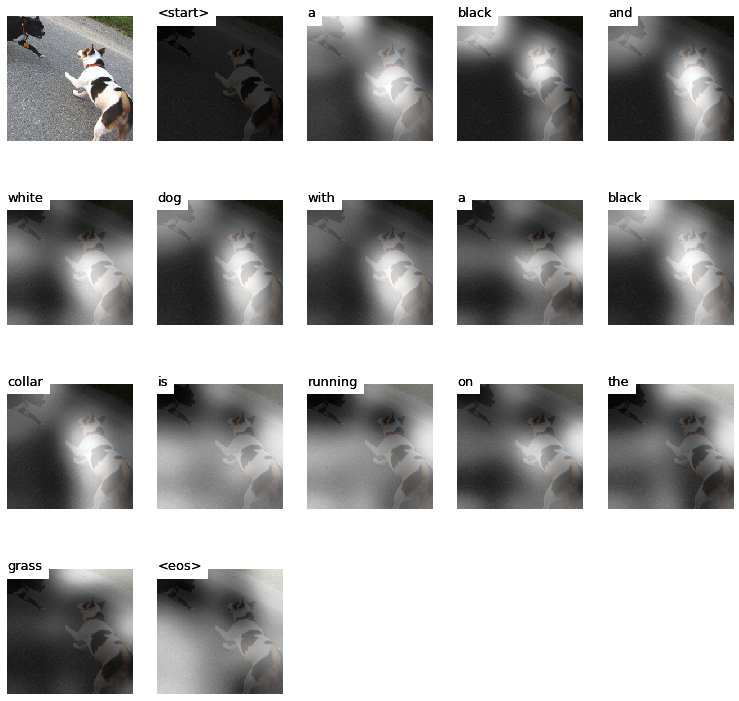

In [ ]:

if __name__ == "__main__":

    args = myArgs2('./Data/Train/Images/1001773457_577c3a7d70.jpg', './model_saved_tf_vgg19_13.pth','./preprocessed_files/', network='vgg19')

    word_dict = load(args.data_path + '/word_dict.json')
    vocabulary_size = len(word_dict)

    encoder = Encoder(network=args.network)
    decoder = Decoder(vocabulary_size, encoder.dim)

    decoder.load_state_dict(torch.load(args.model))

    encoder.eval()
    decoder.eval()
    print("-----Encoder and Decoder put to eval------")
    generate_caption_visualization(encoder, decoder, args.img_path, word_dict)

##  Test Images 

-----Encoder and Decoder put to eval------


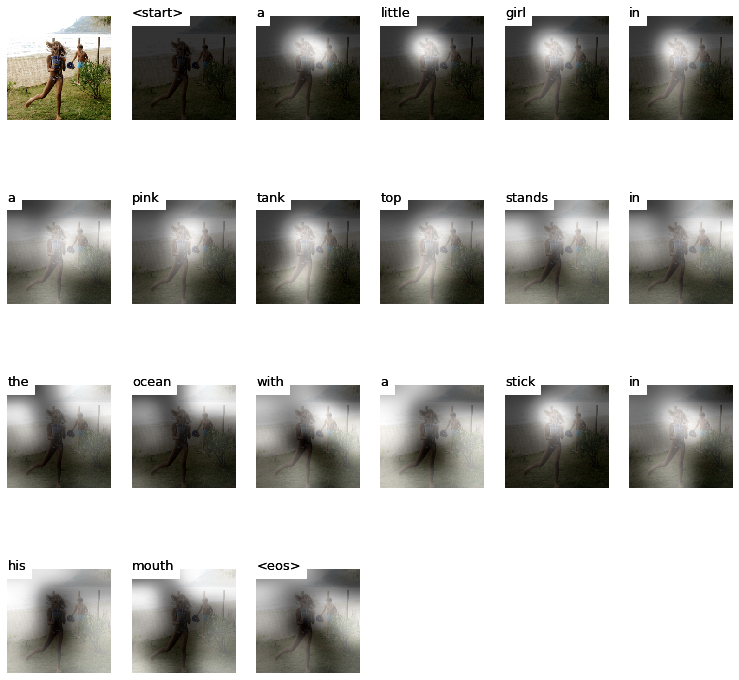

In [ ]:
if __name__ == "__main__":

    args = myArgs2('./Data/Test/Images/2830869109_c4e403eae6.jpg', './model_saved_tf_vgg19_13.pth','./preprocessed_files/', network='vgg19')

    word_dict = load(args.data_path + '/word_dict.json')
    vocabulary_size = len(word_dict)

    encoder = Encoder(network=args.network)
    decoder = Decoder(vocabulary_size, encoder.dim)

    decoder.load_state_dict(torch.load(args.model))

    encoder.eval()
    decoder.eval()
    print("-----Encoder and Decoder put to eval------")
    generate_caption_visualization(encoder, decoder, args.img_path, word_dict)

-----Encoder and Decoder put to eval------


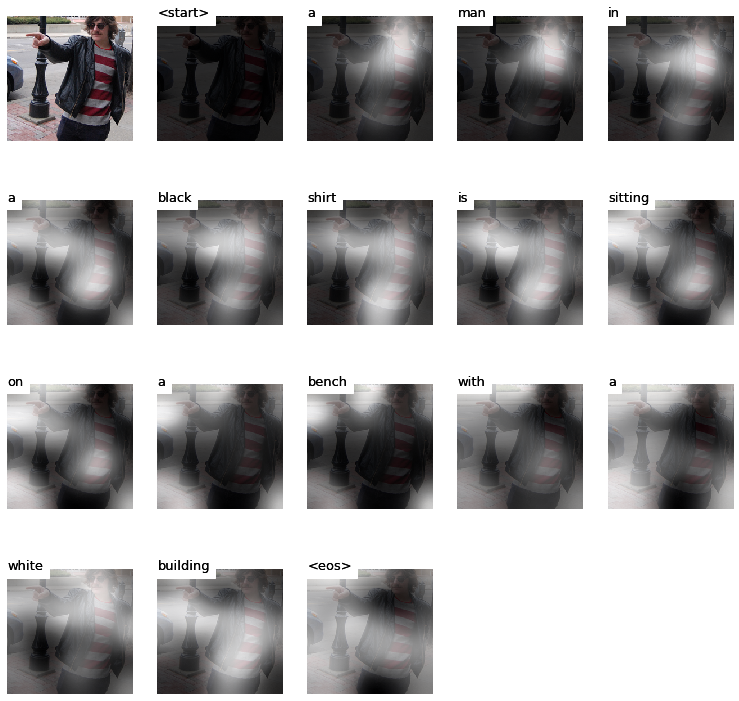

In [ ]:
if __name__ == "__main__":

    args = myArgs2('./Data/Test/Images/3393926562_66cc01b001.jpg', './model_saved_tf_vgg19_13.pth','./preprocessed_files/', network='vgg19')

    word_dict = load(args.data_path + '/word_dict.json')
    vocabulary_size = len(word_dict)

    encoder = Encoder(network=args.network)
    decoder = Decoder(vocabulary_size, encoder.dim)

    decoder.load_state_dict(torch.load(args.model))

    encoder.eval()
    decoder.eval()
    print("-----Encoder and Decoder put to eval------")
    generate_caption_visualization(encoder, decoder, args.img_path, word_dict)

-----Encoder and Decoder put to eval------


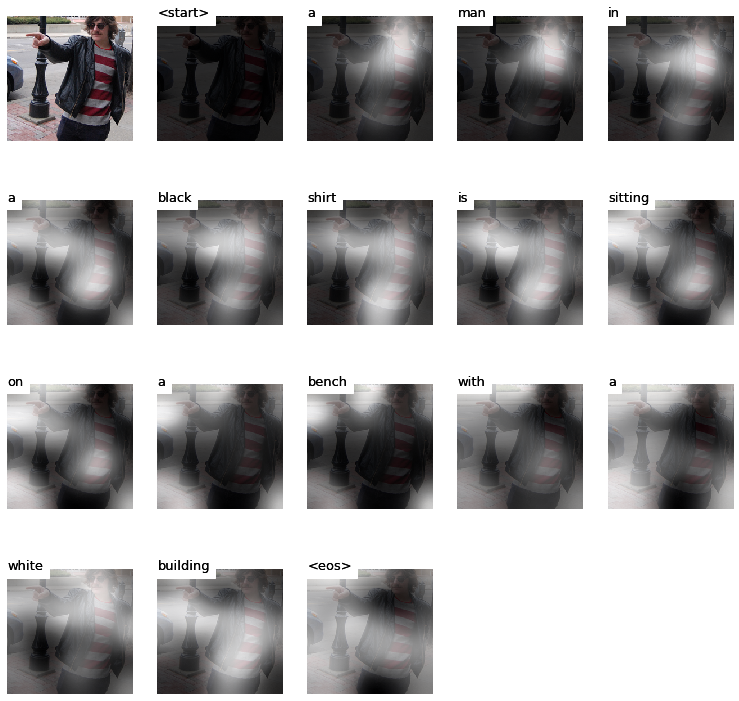

In [ ]:
if __name__ == "__main__":

    args = myArgs2('./Data/Test/Images/3393926562_66cc01b001.jpg', './model_saved_tf_vgg19_13.pth','./preprocessed_files/', network='vgg19')

    word_dict = load(args.data_path + '/word_dict.json')
    vocabulary_size = len(word_dict)

    encoder = Encoder(network=args.network)
    decoder = Decoder(vocabulary_size, encoder.dim)

    decoder.load_state_dict(torch.load(args.model))

    encoder.eval()
    decoder.eval()
    print("-----Encoder and Decoder put to eval------")
    generate_caption_visualization(encoder, decoder, args.img_path, word_dict)

-----Encoder and Decoder put to eval------


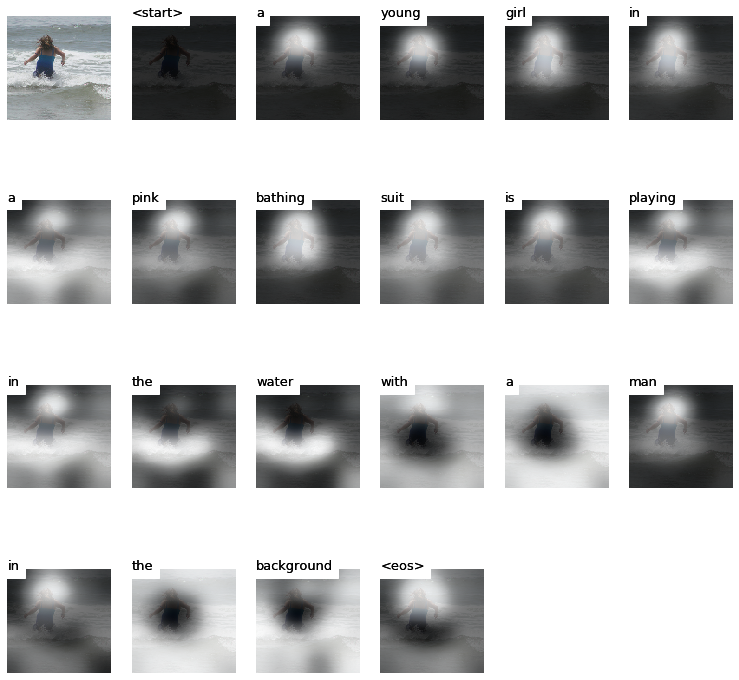

In [ ]:
if __name__ == "__main__":

    args = myArgs2('./Data/Test/Images/2708686056_1b8f356264.jpg', './model_saved_tf_vgg19_13.pth','./preprocessed_files/', network='vgg19')

    word_dict = load(args.data_path + '/word_dict.json')
    vocabulary_size = len(word_dict)

    encoder = Encoder(network=args.network)
    decoder = Decoder(vocabulary_size, encoder.dim)

    decoder.load_state_dict(torch.load(args.model))

    encoder.eval()
    decoder.eval()
    print("-----Encoder and Decoder put to eval------")
    generate_caption_visualization(encoder, decoder, args.img_path, word_dict)

-----Encoder and Decoder put to eval------


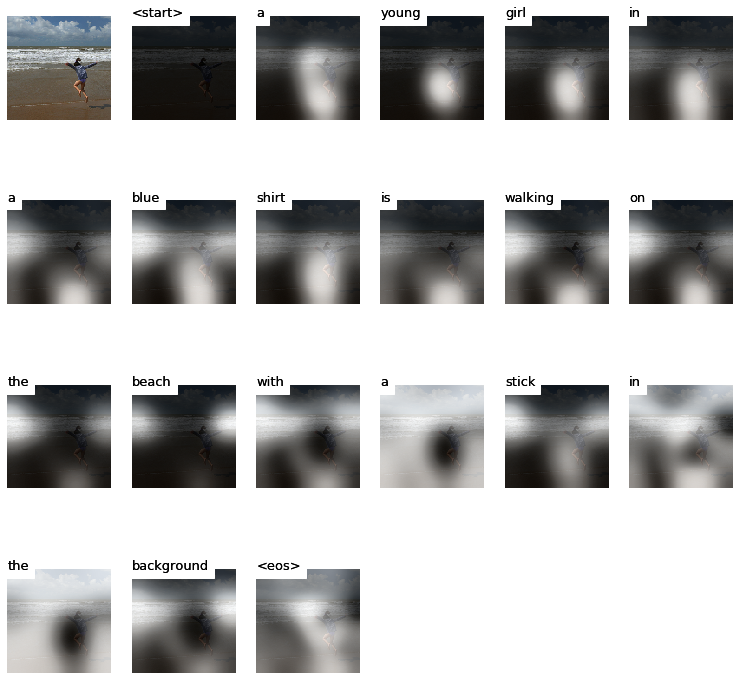

In [ ]:
if __name__ == "__main__":

    args = myArgs2('./Data/Test/Images/1174525839_7c1e6cfa86.jpg', './model_saved_tf_vgg19_13.pth','./preprocessed_files/', network='vgg19')

    word_dict = load(args.data_path + '/word_dict.json')
    vocabulary_size = len(word_dict)

    encoder = Encoder(network=args.network)
    decoder = Decoder(vocabulary_size, encoder.dim)

    decoder.load_state_dict(torch.load(args.model))

    encoder.eval()
    decoder.eval()
    print("-----Encoder and Decoder put to eval------")
    generate_caption_visualization(encoder, decoder, args.img_path, word_dict)

## Val Images 

-----Encoder and Decoder put to eval------


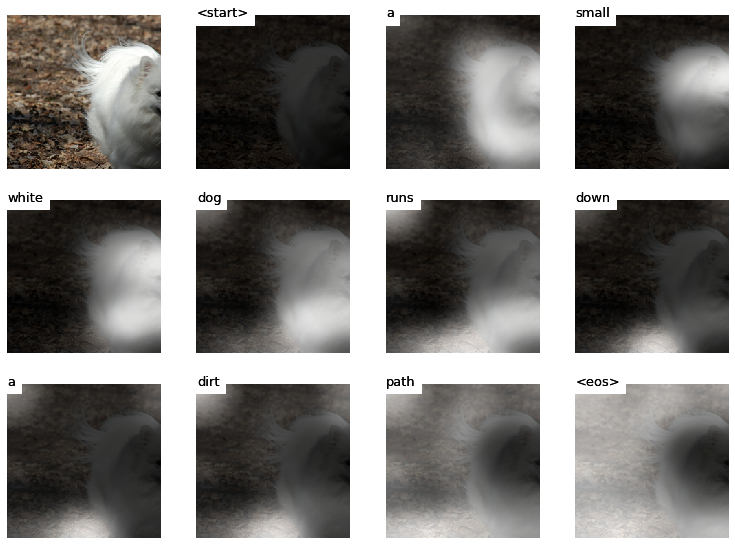

In [ ]:
if __name__ == "__main__":

    args = myArgs2('./Data/Val/Images/3439243433_d5f3508612.jpg', './model_saved_tf_vgg19_13.pth','./preprocessed_files/', network='vgg19')

    word_dict = load(args.data_path + '/word_dict.json')
    vocabulary_size = len(word_dict)

    encoder = Encoder(network=args.network)
    decoder = Decoder(vocabulary_size, encoder.dim)

    decoder.load_state_dict(torch.load(args.model))

    encoder.eval()
    decoder.eval()
    print("-----Encoder and Decoder put to eval------")
    generate_caption_visualization(encoder, decoder, args.img_path, word_dict)

-----Encoder and Decoder put to eval------


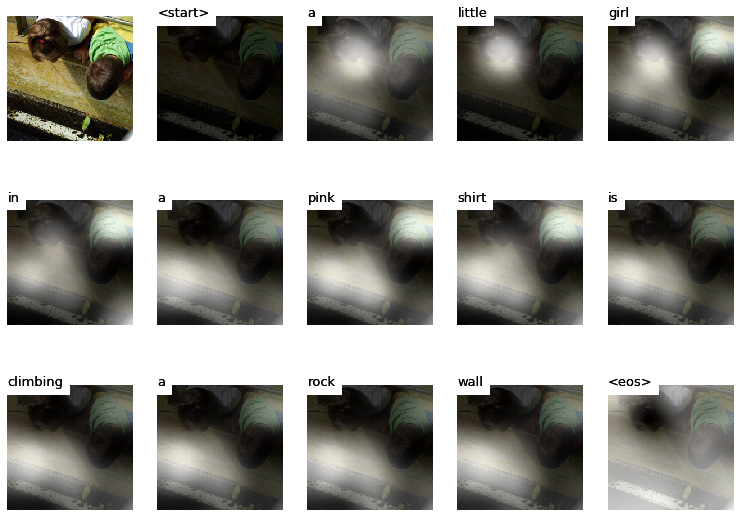

In [ ]:
if __name__ == "__main__":

    args = myArgs2('./Data/Val/Images/2833431496_09d999db4d.jpg', './model_saved_tf_vgg19_13.pth','./preprocessed_files/', network='vgg19')

    word_dict = load(args.data_path + '/word_dict.json')
    vocabulary_size = len(word_dict)

    encoder = Encoder(network=args.network)
    decoder = Decoder(vocabulary_size, encoder.dim)

    decoder.load_state_dict(torch.load(args.model))

    encoder.eval()
    decoder.eval()
    print("-----Encoder and Decoder put to eval------")
    generate_caption_visualization(encoder, decoder, args.img_path, word_dict)

In [ ]:
# !ls
# !ls ./Data/Val/Images/


# Validation Set Scores from final model

In [ ]:


args_val = myArgs('./model_saved_tf_vgg19_13.pth','./preprocessed_files/',batch_size=64,epochs=25, lr=1e-3)


def abc(args,split):
    writer = SummaryWriter()
    word_dict = load(args.data + '/word_dict.json')
    word_dict_reverse = load(args.data + '/word_dict_reverse.json')
    vocabulary_size = len(word_dict)

    encoder = Encoder(args.network)
    decoder = Decoder(vocabulary_size, encoder.dim, args.tf)

    if args.model:
        decoder.load_state_dict(torch.load(args.model))

    encoder.to(device)
    decoder.to(device)

    optimizer = optim.Adam(decoder.parameters(), lr=args.lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, args.step_size)
    cross_entropy_loss = nn.CrossEntropyLoss().to(device)
    
    val_dataloader = torch.utils.data.DataLoader(
            ImageCaptionDataset(data_transforms, args.data, split_type=split),
            batch_size=args.batch_size, shuffle=True, num_workers=1)

    validate(args.epochs, encoder, decoder, cross_entropy_loss, val_dataloader,
                     word_dict, args.alpha_c, args.log_interval, writer,word_dict_reverse)
    
abc(args_val, 'val')

Validation Batch: [0/79]	Loss 2.8055 (2.8055)	
Validation Epoch: 25	BLEU-1 (0.5820045558086561)	BLEU-2 (0.3790741257907318)	BLEU-3 (0.2493781379048156)	BLEU-4 (0.15925891095030295)	METEOR (0.48114907406484453)	


# Test Set Scores from final model

In [ ]:

args_test = myArgs('./model_saved_tf_vgg19_13.pth','./preprocessed_files/',batch_size=64,epochs=25, lr=1e-3)


def abc(args,split):
    writer = SummaryWriter()
    word_dict = load(args.data + '/word_dict.json')
    word_dict_reverse = load(args.data + '/word_dict_reverse.json')
    vocabulary_size = len(word_dict)

    encoder = Encoder(args.network)
    decoder = Decoder(vocabulary_size, encoder.dim, args.tf)

    if args.model:
        decoder.load_state_dict(torch.load(args.model))

    encoder.to(device)
    decoder.to(device)

    optimizer = optim.Adam(decoder.parameters(), lr=args.lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, args.step_size)
    cross_entropy_loss = nn.CrossEntropyLoss().to(device)
    
    val_dataloader = torch.utils.data.DataLoader(
            ImageCaptionDataset(data_transforms, args.data, split_type=split),
            batch_size=args.batch_size, shuffle=True, num_workers=1)

    validate(args.epochs, encoder, decoder, cross_entropy_loss, val_dataloader,
                     word_dict, args.alpha_c, args.log_interval, writer,word_dict_reverse)
    
abc(args_test, 'test')

Validation Batch: [0/79]	Loss 2.5919 (2.5919)	
Validation Epoch: 25	BLEU-1 (0.5955487336914812)	BLEU-2 (0.38881528829106726)	BLEU-3 (0.25470391139071946)	BLEU-4 (0.1628315203196289)	METEOR (0.5303297979326735)	
